In [1]:
import os
os.environ['ENV'] = 'prod'
os.environ['REGION'] = 'apse1'
os.environ['TENANT'] ="in"
os.environ['RECO_S3_BUCKET'] = "p13n-reco-offline-prod"
os.environ['COUNTRY_KEY']= "in"
os.environ['AWS_REGION']= "ap-southeast-1"
os.environ['USE_REAL_CMS3']= "True"
os.environ['RECO_CREDENTIAL']= "-----BEGINRSAPRIVATEKEY-----\nMGICAQACEQCdHOlGnxIMWCMzjK2JAg37AgMBAAECEGOIwGTEO9vd3X9+jyiF4NECCQnoqDakDgSm2QIID9sadWN0XvMCCQLiqPkgVKSuIQIIDCAsWM+pJB8CCQG0jbIGCNX9MA==\n-----ENDRSAPRIVATEKEY-----"

from datetime import datetime, timedelta
import argparse, gc
import json
import os, time
import numpy as np
import s3fs
import pyarrow
import tensorflow as tf
from tqdm import tqdm

tfv1 = tf.compat.v1
tfv1.disable_v2_behavior()

# Enable memory growth for GPUs to avoid memory fragmentation
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

import tensorflow_addons as tfa
import tensorflow_recommenders_addons as tfra

from common.config.utils import data_path, model_path
from common.config import TENANT
from tpfy.tf_model.tpfy_model_v3_mtl import TpfyModelV3, TpfyMtlModelConfig
from tpfy.etl.schema import TpfyMtlDatasetSchema
from model.parquet_dataset import TFParquetDataset
from tpfy.common import TpfyDataPath
from omegaconf import OmegaConf
from dataclasses import dataclass
from tpfy.train_v3_mtl import make_example_mtl, TpfyTrainConfig, TpfyConfig
from tpfy.helper import load_model_weights_from_s3
import pandas as pd
from model.losses import masked_binary_entropy_loss
from model.metrics import MaskedAUC
from sklearn.metrics import mean_squared_error
import pickle

def create_dataset(date, path = None):
    if path:
        data_path_str = path
    else:
        data_path_str = data_path(
            TpfyDataPath.S3_TPFY_IMPR_V3_AGG_MTL_EXTRACTED_EXAMPLES_VAR, TENANT
        ) % (variant, date)

    dataset = TFParquetDataset([data_path_str], TpfyMtlDatasetSchema, shuffle_files=True)
    print(f'Batch size : {batch_size}')
    tf_dataset = dataset.create_tf_dataset(batch_size).map(make_example_mtl)
    return tf_dataset

def load_and_compile_model():
    # Build model
    print(f"\n{'='*80}")
    print("BUILDING MODEL")
    print(f"{'='*80}")

    model = TpfyModelV3(
        hparams.model,
        click_ns=args.click_ns,
        enable_random_watch=hparams.train.enable_random_watch,
    )

    # Create optimizer (needed for compilation, even though we won't train)
    optimizer = tfa.optimizers.AdamW(
        weight_decay=0.0,  # Not needed for inference
        learning_rate=0.001,  # Not needed for inference
        epsilon=1e-4,
    )

    loss_dict = {
            "click": masked_binary_entropy_loss(from_logits=True),
            "watch": masked_binary_entropy_loss(from_logits=True),
            "random_watch": masked_binary_entropy_loss(from_logits=False),
            "paywall_view": masked_binary_entropy_loss(from_logits=True),
            "add_watchlist": masked_binary_entropy_loss(from_logits=True),
    }
    metric_dict = {
            "click": MaskedAUC(from_logits=True),
            "watch": MaskedAUC(from_logits=True),
            "random_watch": MaskedAUC(from_logits=False),
            "paywall_view": MaskedAUC(from_logits=True),
            "add_watchlist": MaskedAUC(from_logits=True),
    }

    optimizer = tfra.dynamic_embedding.DynamicEmbeddingOptimizer(optimizer)

    model.compile(optimizer=optimizer, loss=loss_dict, metrics=metric_dict)
    print("Model compiled")
    
    return model

def get_activations_and_labels(iterator, model, last_layer_tensor):
    features, labels, metadata = session.run(iterator)

    # Run model
    predictions = model(features, training=False)

    # Execute
    pred_values, activation_values = session.run(
        [predictions, last_layer_tensor]
    )

    return activation_values, labels, pred_values, metadata

def validation(iterator, model, last_layer_tensor, d=128, runs=10):
    def linucb_inference(
        H,
        content_ids,
        theta,
        A_inv,
        arm_dict,
        lambda_reg=1.0
    ):
        B, d = H.shape

        mean = np.zeros(B, dtype=np.float32)
        var  = np.zeros(B, dtype=np.float32)

        for i, cid in enumerate(content_ids):
            h = H[i]

            if cid in arm_dict:
                idx = arm_dict[cid]
                mean[i] = h @ theta[idx]
                var[i] = h @ (A_inv[idx] @ h)
            else:
                # ---- cold-start arm ----
                mean[i] = 0.0
                var[i] = (h @ h) / lambda_reg
        std = np.sqrt(np.maximum(var, 1e-8))
        return mean, std
    
    # Use numpy arrays with preallocated size to avoid dynamic list growth
    all_predictions = []
    all_labels = []
    all_variances = []
    all_content_ids = []
    all_dw_p_ids = []
    all_timestamps = []
    all_deepFMpredictions = []
    # mse_sum = 0.0
    valid_runs = 0

    for i in range(runs):
        try:
            H, y_batch_all_labels, pred_values, metadata = get_activations_and_labels(iterator, model, last_layer_tensor)
            y_batch = y_batch_all_labels['click']
            pred_values = pred_values['click']

            mask = (y_batch != -1)

            if not np.any(mask):
                continue

            H = H[mask.squeeze()]
            y_batch = y_batch[mask].reshape(sum(mask)[0], 1)
            pred_values = pred_values[mask].reshape(sum(mask)[0], 1)
            content_id = [content_id for content_id, mask_bool in zip(metadata['content_id'], mask) if mask_bool]

            H = H / (np.linalg.norm(H, axis=1, keepdims=True) + 1e-8)
            mean, variance = linucb_inference(H, content_id, theta, A_inv, arm_dict)
            # variance = np.sqrt(np.diag(H @ A_inv @ H.T))
            # mean = H@theta

            # Append to lists (will concatenate once at the end)
            all_predictions.append(mean)
            all_deepFMpredictions.append(pred_values)
            all_labels.append(y_batch)
            all_variances.append(variance)
            all_content_ids.extend(content_id)
            all_dw_p_ids.extend([dw_p_id for dw_p_id, mask_bool in zip(metadata['dw_p_id'], mask) if mask_bool])
            all_timestamps.extend([timestamp for timestamp, mask_bool in zip(metadata['timestamp'], mask) if mask_bool])
            # mse_sum += mean_squared_error(y_batch, mean)
            valid_runs += 1

            # Clean up intermediate variables
            del H, y_batch, pred_values, mask, variance, y_batch_all_labels, metadata, mean, content_id

        except tf.errors.OutOfRangeError:
            print(f"Iterator exhausted at run {i}")
            break

    if valid_runs == 0:
        return None, None, None, None, None, None

    # Concatenate once at the end (more memory efficient)
    predictions = np.concatenate(all_predictions, axis=0)
    deepFMpredictions = np.concatenate(all_deepFMpredictions, axis=0)
    labels = np.concatenate(all_labels, axis=0) if all_labels else np.array([])
    variances = np.concatenate(all_variances, axis=0) if all_variances else np.array([])

    # Clean up lists
    del all_labels, all_variances, all_deepFMpredictions, all_predictions

    return deepFMpredictions, labels, predictions, variances, all_content_ids, all_dw_p_ids, all_timestamps

def compute_A_inv_and_theta(A, b):
    m, d, _ = A.shape

    A_inv = np.zeros_like(A)
    theta = np.zeros_like(b)

    for i in tqdm(range(m)):
        # Solve A_i x = I instead of explicit inverse (more stable)
        A_inv[i] = np.linalg.solve(A[i], np.eye(d))
        theta[i] = A_inv[i] @ b[i]

    return A_inv, theta

# parser = argparse.ArgumentParser(description="TPFY Exploration offline Training.")
# parser.add_argument("model_name", type=str)
# parser.add_argument("date", type=str)
# parser.add_argument("--click_ns", type=float, default=0.08)
# parser.add_argument("--variant", type=str, default="cms3")
# parser.add_argument("--batch_size", type=int, default=512)
# parser.add_argument("--clear_nn", action="store_true", default=False)
# parser.add_argument("--checkpoint", default=None, type=str)
# parser.add_argument("--layer_name", default='Relu', type=str)
# parser.add_argument("--matrix_strategy", default='cumulative', type=str)
# parser.add_argument("--validation_run", default=1100, type=int)

# args = parser.parse_args()

class Args:
    """Simple class to hold training arguments (replaces argparse)"""
    def __init__(self):
        # Positional arguments
        self.model_name = "tpfy-v3-mtl-r2"
        self.date = "2026-02-09"  # Training date
        self.click_ns = 0.08
        self.variant = "cms3"
        self.batch_size = 512
        self.clear_nn = False
        self.checkpoint = '1770723470'
        self.layer_name = 'Relu'
        self.validation_run = 600
        
args = Args()

content_popularity_tag = pd.read_csv('Content_popularity_tag_26Jan_to_1Feb.csv')
content_popularity_tag.drop_duplicates(subset=['sub_title_id'], inplace = True)
content_popularity_tag.reset_index(drop = True, inplace = True)
content_popularity_dict = content_popularity_tag.set_index('sub_title_id')['popularity_tag'].to_dict()    

# Load configuration
config_name = f"tpfy/tpfy_config/mtl-{TENANT}.yaml"
if not os.path.exists(config_name):
    raise FileNotFoundError(f"Config file {config_name} not found")

hparams: TpfyConfig = OmegaConf.merge(
    OmegaConf.structured(TpfyConfig),
    OmegaConf.load(config_name),
)
print(f"\nLoaded config: {config_name}")

# Override batch size if specified
if args.batch_size:
    hparams.train.batch_size = args.batch_size

batch_size = hparams.train.batch_size
print(f"Batch size: {batch_size}")

# Load dataset
variant = args.variant
if variant and not variant.startswith("-"):
    variant = "-" + variant

session = tfv1.keras.backend.get_session()

date_obj = datetime.strptime(args.date, "%Y-%m-%d")
next_day = date_obj + timedelta(days=1)
validation_date = next_day.strftime("%Y-%m-%d")
validation_data_path = f's3://p13n-reco-offline-prod/upload_objects/test_vedansh/daily-mtl-extracted-cms3-minimum-5-contents/cd={validation_date}/'
tf_dataset = create_dataset(args.date, validation_data_path)
iterator = tf_dataset.make_one_shot_iterator()
next_batch = iterator.get_next()
sample_features, sample_labels, sample_metadata = session.run(next_batch)
tpfy_model = load_and_compile_model()

prediction = tpfy_model(sample_features, training=False)
session.run([
    tfv1.global_variables_initializer(),
    tfv1.local_variables_initializer(),
    tfv1.tables_initializer()
])

plain_weights = load_model_weights_from_s3(
    args.model_name,
    use_s3=True,
    checkpoint_name=args.checkpoint
)
plain_weights_modified = {k.replace('train/', ''): v for k, v in plain_weights.items()}
restore_ops = tpfy_model.restore_plain_weights_ops(
    plain_weights_modified,
    clear_nn=args.clear_nn
)
session.run(restore_ops)

# Create NEW iterator (reset to start of dataset)
iterator = tf_dataset.make_one_shot_iterator()
next_batch = iterator.get_next()

# Get compress_output tensor (linear_input)
graph = tf.compat.v1.get_default_graph()
compress_output_tensor = graph.get_tensor_by_name(f'tpfy_model_v3/deepfm/{args.layer_name}:0')

2026-02-13 17:02:08.986571: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-02-13 17:02:08.986600: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


2026-02-13 17:02:10.009510: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2026-02-13 17:02:10.009534: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2026-02-13 17:02:10.009549: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-11-72-173): /proc/driver/nvidia/version does not exist



Loaded config: tpfy/tpfy_config/mtl-in.yaml
Batch size: 512

files s3://p13n-reco-offline-prod/upload_objects/test_vedansh/daily-mtl-extracted-cms3-minimum-5-contents/cd=2026-02-10/part-00189-tid-1126887162240719321-ff3a67b9-1a78-47e4-9227-0c4087d33682-3492-1-c000.snappy.parquet,s3://p13n-reco-offline-prod/upload_objects/test_vedansh/daily-mtl-extracted-cms3-minimum-5-contents/cd=2026-02-10/part-00186-tid-1126887162240719321-ff3a67b9-1a78-47e4-9227-0c4087d33682-3489-1-c000.snappy.parquet,s3://p13n-reco-offline-prod/upload_objects/test_vedansh/daily-mtl-extracted-cms3-minimum-5-contents/cd=2026-02-10/part-00003-tid-1126887162240719321-ff3a67b9-1a78-47e4-9227-0c4087d33682-3306-1-c000.snappy.parquet,s3://p13n-reco-offline-prod/upload_objects/test_vedansh/daily-mtl-extracted-cms3-minimum-5-contents/cd=2026-02-10/part-00017-tid-1126887162240719321-ff3a67b9-1a78-47e4-9227-0c4087d33682-3320-1-c000.snappy.parquet,s3://p13n-reco-offline-prod/upload_objects/test_vedansh/daily-mtl-extracted-cms3

2026-02-13 17:02:10.828264: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.


2026-02-13 17:02:11.286731: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2499995000 Hz
2026-02-13 17:02:11.333834: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)



BUILDING MODEL
Model compiled
--------------
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
q Tensor("tpfy_model_v3/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3/

2026-02-13 17:02:15.100181: I ./tensorflow_recommenders_addons/dynamic_embedding/core/kernels/lookup_impl/lookup_table_op_cpu.h:143] HashTable on CPU is created on optimized mode: K=l, V=f, DIM=32, init_size=8192


In [2]:
lambda_=1.0
d=128
A = np.load(f'disjoint_neural_linucb/disjoined_neural_linUCB_offline_matrices_{args.date}_{args.checkpoint}/A_9000.npy')
b = np.load(f'disjoint_neural_linucb/disjoined_neural_linUCB_offline_matrices_{args.date}_{args.checkpoint}/b_9000.npy')
arm_dict = pd.read_pickle(f'disjoint_neural_linucb/disjoined_neural_linUCB_offline_matrices_{args.date}_{args.checkpoint}/arm_index_9000.pkl')
A_inv, theta = compute_A_inv_and_theta(A, b)
# # run = 0
steps = 100

os.makedirs(f'disjoint_neural_linucb/disjoined_neural_linUCB_offline_matrices_{args.date}_{args.checkpoint}/validation_dumping_dict_{args.date}', exist_ok=True)
for run in range(0, args.validation_run, 100):
    start = time.time()
    # Find the validation evals for 10 runs
    val_results = validation(next_batch, tpfy_model, compress_output_tensor, runs=steps)

    if val_results[0] is None:
        print(f"Validation failed at run {run}, skipping metrics")
        run += 100
        continue

    deepFMpredictions, labels, means, variances, content_ids, dw_p_ids, timestamps = val_results

    # Save results
    dumping_dict = {
        'dw_p_ids': dw_p_ids,
        'timestamps': timestamps,
        'content_ids': content_ids,
        'deepFMpredictions': deepFMpredictions.flatten(),
        'labels': labels.flatten(),
        'variances': variances,
        'means': means
    }

    with open(f'disjoint_neural_linucb/disjoined_neural_linUCB_offline_matrices_{args.date}_{args.checkpoint}/validation_dumping_dict_{args.date}/validation_stats_run_{run}.pkl', 'wb') as handle:
        pickle.dump(dumping_dict, handle)

    # Clean up large objects explicitly
    del labels, variances, content_ids, deepFMpredictions, dw_p_ids, timestamps, val_results, means

    # Force garbage collection and clear TF cache
    gc.collect()

    # run += steps
    print(f'Run {run} completed in {time.time() - start} s!')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7788/7788 [01:31<00:00, 85.20it/s]


--------------
q Tensor("tpfy_model_v3_1/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_1/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_1/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_1/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_1/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_1/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_1/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_1/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_1/deepfm/fwfm/Reshape:0", shape=(512,

KeyboardInterrupt: 

In [3]:
result_dict = pd.read_pickle(f'disjoint_neural_linucb/disjoined_neural_linUCB_offline_matrices_2026-02-09_1770723470/validation_dumping_dict_2026-02-09/validation_stats_run_0.pkl')


In [4]:
result_dict['variances']

array([0.2081149 , 0.14959101, 0.08519947, ..., 0.09865172, 0.05175066,
       0.18988016], dtype=float32)

In [5]:
result_dict['means']

array([0.48248166, 0.19917388, 0.3872674 , ..., 0.29980934, 0.43418682,
       0.47269145], dtype=float32)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

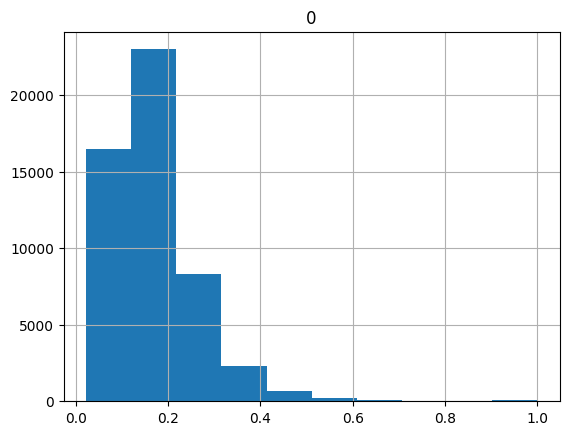

In [6]:
pd.DataFrame(result_dict['variances']).hist()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

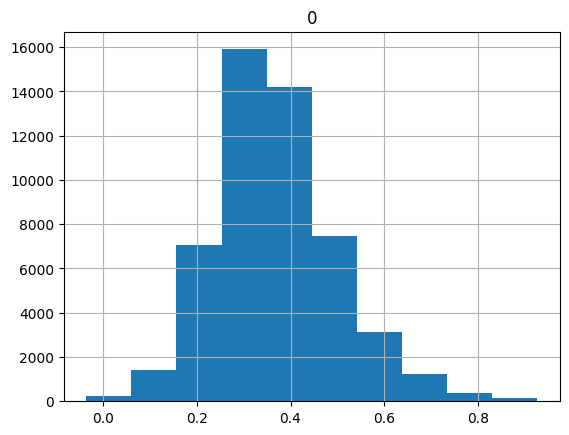

In [7]:
pd.DataFrame(result_dict['means']).hist()